In [42]:
import sympy
from sympy import powdenest
from IPython.display import display
from einsteinpy.symbolic import MetricTensor, ChristoffelSymbols, RiemannCurvatureTensor
sympy.init_printing()

In [78]:
def calc_hesse(coords: list, g_fm: MetricTensor, V):
  #We have to calculate covariant derivatives using the covariant derivative of
  #V using the christoffel symbols of g_fm
  dim = len(coords)
  conn = ChristoffelSymbols.from_metric(g_fm).tensor()
  Vab = [[0 for _ in range(dim)] for _ in range(dim)]
  for a in range(dim):
    for b in range(dim):
      da_dbV = sympy.diff(V, coords[b], coords[a]).simplify()
      gamma_ab = 0
      for c in range(dim):
        gamma_ab = (gamma_ab + conn[a][b][c]*sympy.diff(V, coords[c])).simplify()
      Vab[a][b] = da_dbV - gamma_ab
  return Vab

def inner_prod(vec1: list, vec2: list, metric: MetricTensor):
  """returns the inner product of vec1 and vec2 with respect to the supplied metric

  Args:
    vec1 (list): first vector, once contravariant
    vec2 (list): second vector, once contravariant
    metric (MetricTensor): metric tensor, twice covariant

  Returns:
    symbolic sympy expression: inner product of vec1 with vec2 with respect to
    the specified metric tensor
  """
  assert(len(vec1) == len(vec2))
  ans = 0
  for a in range(len(vec1)):
    for b in range(len(vec2)):
      ans = ans + vec1[a]*vec2[b]*metric.arr[a][b]
  return powdenest(ans.simplify(), force=True)

def normalize(vec: list, metric: MetricTensor):
  norm = sympy.sqrt(inner_prod(vec, vec, metric))
  return [powdenest((cmp / norm).simplify(), force=True) for cmp in vec]

def calc_v(coords: list, g_fm: MetricTensor, V):
  dim = len(coords)
  norm = (1 / sympy.sqrt(sympy.Matrix(g_fm.arr).det())).simplify()
  
  #Non-normalised components of grad V
  va = [0 for _ in range(dim)]
  for a in range(dim):
    va[a] = powdenest((sympy.diff(V, coords[a]) * norm).simplify(), force=True)
  return normalize(va, g_fm)

def calc_next_w(current_basis: list, guess: list, g: MetricTensor):
  """Use the Gramm-Schmidt procedure to find a new orthogonal basis vector given
  an incomplete set of orthogonal basis vectors and a third vector that is linearly
  independent from the other vectors.

  Args:
    current_basis (list(list)): list of current *orthogonal* basisvectors. The
      components of the vectors should be given in *contravariant* form.
    guess (list): vector that is linearly independent from the (incomplete) set of
      current basis vectors. The components of this vector should be given in
      *contravariant* form. This vector needn't be normalized nor orthogonal to
      the set of current basis vectors.
    g (MetricTensor): metric tensor (twice covariant) used to define inner products
      for the Gramm-Schmidt procedure

  Returns:
    (list): list of the contravariant components of an additional basis vector
      orthogonal to the supplied set of basis vectors, with respect to the supplied
      metric.
  """
  dim = len(current_basis[0])
  #make sure the supplied basis is not already complete
  assert(len(current_basis) < dim)
  ans = guess
  for vec in current_basis:
    overlap = inner_prod(vec, guess, g)
    for a in range(dim):
      ans[a] = (ans[a] - overlap*vec[a]).simplify()
  return normalize(ans, g)

def project_hesse(hesse_matrix: list, vec1: list, vec2: list):
  dim = len(vec1)
  assert(len(vec1) == len(vec2))
  V_proj = 0
  for a in range(dim):
    for b in range(dim):
      V_proj = V_proj + hesse_matrix[a][b]*vec1[a]*vec2[b]
  return powdenest(V_proj.simplify(), force=True)

In [79]:
φ, θ, ψ = sympy.symbols('φ θ ψ')
d = 3
coords = [φ, θ, ψ]

g = [[0 for _ in range(d)] for _ in range(d)]
g[0][0] = 1
g[1][1] = φ**2
g[2][2] = (φ**2) * (sympy.sin(θ)**2)
g = MetricTensor(g ,(φ, θ, ψ))
display(g.tensor())

⎡1  0       0     ⎤
⎢                 ⎥
⎢    2            ⎥
⎢0  φ       0     ⎥
⎢                 ⎥
⎢        2    2   ⎥
⎣0  0   φ ⋅sin (θ)⎦

In [80]:
V0, m, φ0, θ0, ψ0 = sympy.symbols("V0 m φ0 θ0 ψ0")
V = (V0 + 1/2 * m**2 * (φ - φ0)**2 - θ*θ0 - ψ*ψ0).nsimplify()
display(V)

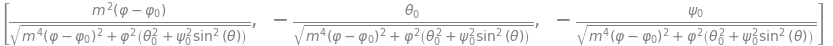

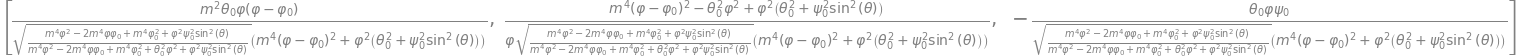

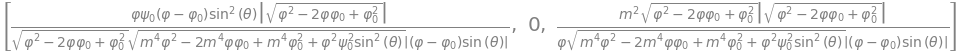

In [83]:
#Calculate the gradient basis
basis = [calc_v(coords, g, V)]
display(basis[0])
for i in range(d - 1):
  next_guess = [0 for _ in range(d)]
  next_guess[i + 1] = 1
  w = normalize(calc_next_w(basis, next_guess, g), g)
  display(w)
  basis.append(w)

In [84]:
#sanity check
for a in range(d):
  for b in range(d):
    print(f"w[{a}]*w[{b}]={inner_prod(basis[a], basis[b], g)}")

w[0]*w[0]=1
w[0]*w[1]=0
w[0]*w[2]=0
w[1]*w[0]=0
w[1]*w[1]=1
w[1]*w[2]=0
w[2]*w[0]=0
w[2]*w[1]=0
w[2]*w[2]=1


In [85]:
H = calc_hesse(coords, g, V)
display(sympy.Matrix(H))

⎡ 2                              2       ⎤
⎢m       -θ₀⋅φ          -φ⋅ψ₀⋅sin (θ)    ⎥
⎢                                        ⎥
⎢      2                                 ⎥
⎢θ₀  -m ⋅(φ - φ₀)       -ψ₀⋅sin(2⋅θ)     ⎥
⎢──  ─────────────      ─────────────    ⎥
⎢φ         φ                  2          ⎥
⎢                                        ⎥
⎢                           2            ⎥
⎢ψ₀       ψ₀           2   m ⋅φ₀     θ₀  ⎥
⎢──     ──────      - m  + ───── + ──────⎥
⎣φ      tan(θ)               φ     tan(θ)⎦

H00=


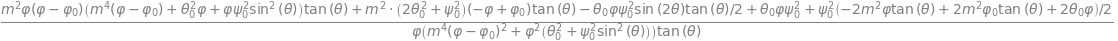

H01=


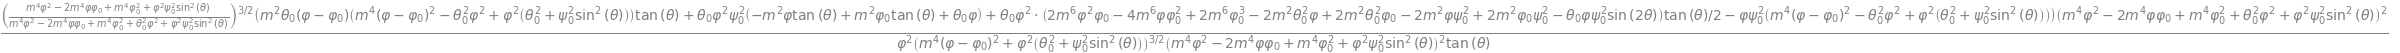

H02=


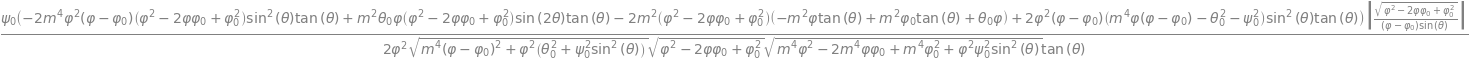

H10=


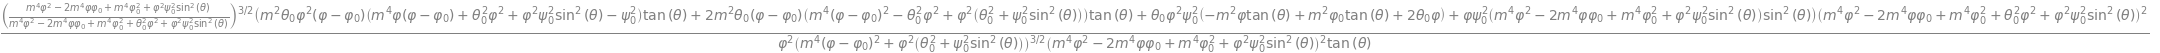

H11=


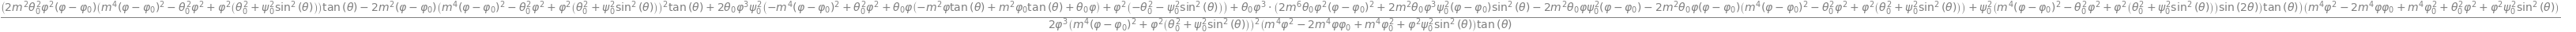

H12=


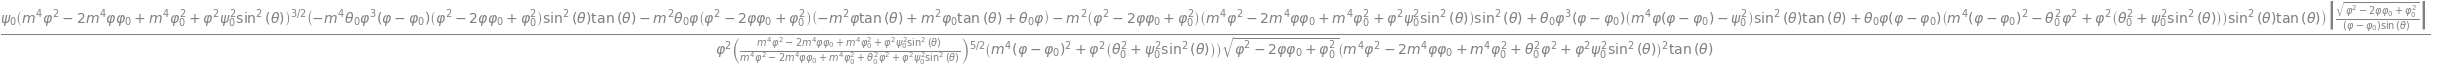

H20=


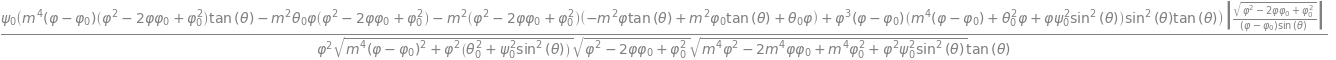

H21=


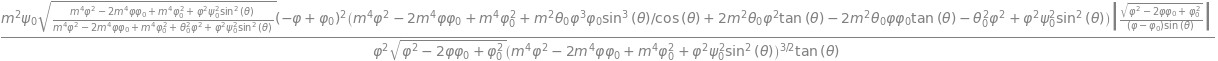

H22=


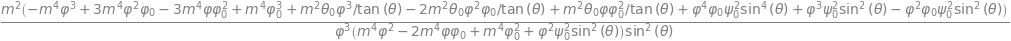

In [86]:
from joblib import Parallel, delayed
def process(a:int, b:int):
  return ([a, b], project_hesse(H, basis[a], basis[b]))

results = Parallel(n_jobs=8)(delayed(process)(a, b) for a in range(d) for b in range(d))
for (idx, result) in results:
  print(f"H{idx[0]}{idx[1]}=")
  display(result)